In [361]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from zipfile import ZipFile
from functools import reduce

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [ ]:
!pip install -q gdown httpimport
!gdown 'https://github.com/wenjie-hoo/baltic_ml/raw/main/2022.11.07-merged-single-observation.zip'

In [386]:
zip_file = ZipFile('./2022.11.07-merged-single-observation.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv') and not text_file.filename[37:].startswith('.')}

df_list=[]
for df in dfs.values():
       df['DATE'] = pd.to_datetime(df['DATE'],dayfirst = True)
       df_list.append(df)

df = reduce(lambda left,right: pd.merge(left.drop_duplicates(subset=['DATE','DEPTH']),right.drop_duplicates(subset=['DATE','DEPTH']),on=['DATE','DEPTH'],how='outer'), df_list)
# df.to_csv('xxxxx.csv')
# df.head

In [368]:
# Fill in missing data
for i in df.columns:
    df[i].fillna(df[i].mean(), inplace=True)

/var/folders/zf/z_5ht60d3n7gfsmz14cjq6fc0000gn/T/ipykernel_16604/76482008.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),vmax=1, annot=True, linewidths=0.5, cbar=False, cmap='YlGnBu',annot_kws={'fontsize':10})


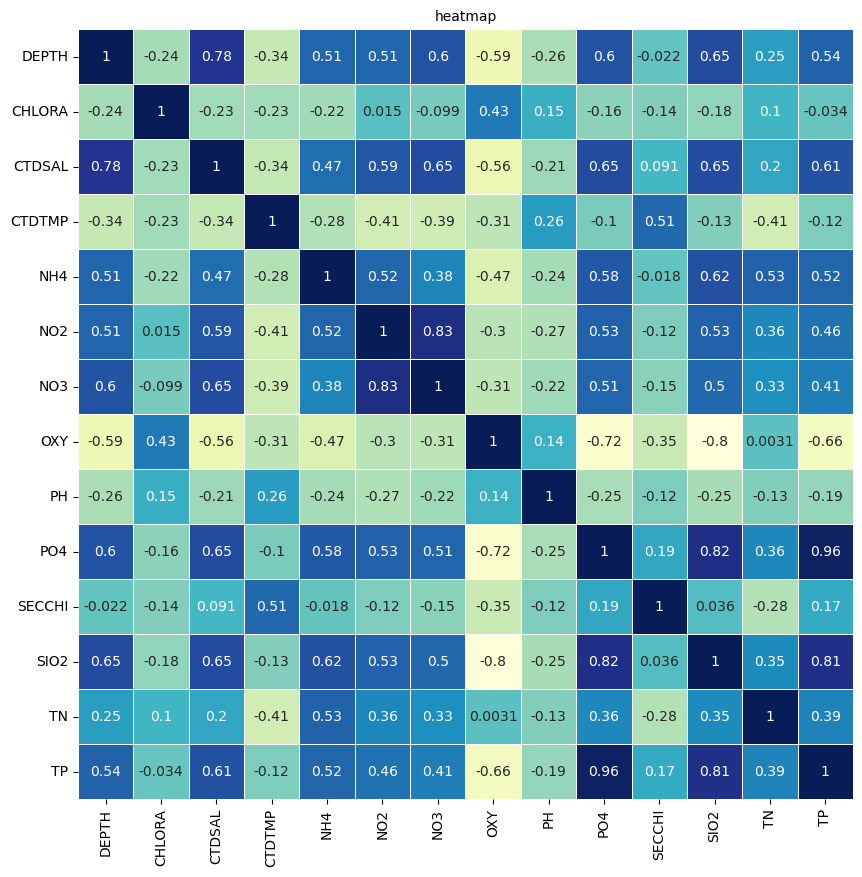

In [387]:
df.dropna(inplace=True)
fig = plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),vmax=1, annot=True, linewidths=0.5, cbar=False, cmap='YlGnBu',annot_kws={'fontsize':10})
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('heatmap',fontsize=10)
plt.show()

In [388]:
X = df.drop(['DATE','OXY','TP','NO2'],axis=1)
y = df[['OXY','TP','NO2']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [389]:
x_train['PO4']  = x_train['PO4'] * 0.5
# x_train['TP']  = x_train['TP'] * 0.5
x_train['TN']  = x_train['TN'] * 0.5
x_train['SIO2']  = x_train['SIO2'] * 0.8

In [390]:
scaler = StandardScaler(with_mean = True, with_std = True)
scaler.fit(x_train)
norm_X = scaler.transform(x_train)
norm_X_test = scaler.transform(x_test)

In [391]:
# linear regression
lg = LinearRegression()
lg.fit(norm_X, y_train)
y_pred = lg.predict(norm_X_test)
print(mean_squared_error(y_test,y_pred))

1944.6052046211882


In [392]:
# neural netword
mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=(2,2), solver='sgd', max_iter=3000)
mlp.fit(norm_X,y_train)
y_pred = mlp.predict(norm_X_test)
print(mean_squared_error(y_test, y_pred))

612.8877800302204


In [393]:
# random forest 
rfr = RandomForestRegressor(random_state=0)
rfr.fit(norm_X, y_train)
y_pred = rfr.predict(norm_X_test)
print(mean_squared_error(y_test, y_pred))

278.31424708279997


1 SIO2 0.6333133440677008
2 CTDTMP 0.15706948709843388
3 CHLORA 0.05861095497617614
4 CTDSAL 0.03305630504743297
5 NH4 0.028271486284823212
6 PO4 0.024980733354357302
7 DEPTH 0.020334850212490062
8 TN 0.015415124657539038
9 NO3 0.011261009326770998
10 SECCHI 0.01014441352155632


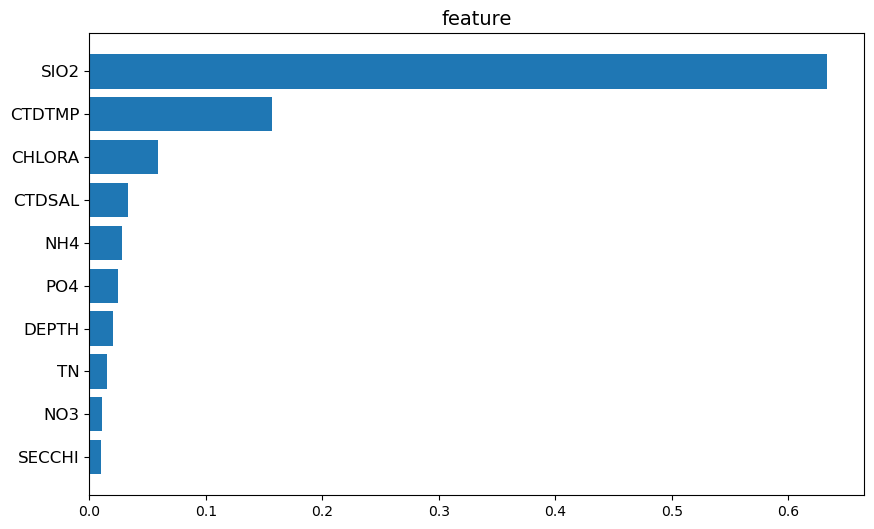

In [394]:
feat_lebels = x_train.columns[0:]
importances  = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
index_list = []
value_list = []
for i,j in zip(range(x_train.shape[1]-1),indices):
    index_list.append(feat_lebels[j])
    value_list.append(importances[j])
    print(i+1, feat_lebels[j], importances[j])

plt.figure(figsize=(10,6))
plt.barh(index_list[::-1],value_list[::-1])
plt.yticks(fontsize = 12)
plt.title('feature',fontsize = 14)
plt.show()

In [417]:
# find best parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators':[150,200,300],
    'min_samples_split':[2,3,5],
    'min_samples_leaf':[1,2,3]
}
grid_seach_rf= GridSearchCV(estimator=RandomForestRegressor(random_state=0),param_grid=param_grid, scoring='neg_mean_squared_error', cv = 5)
grid_seach_rf.fit(norm_X, y_train)
print(grid_seach_rf.best_params_)

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [423]:
# model
rfr_ = RandomForestRegressor(n_estimators=150, min_samples_leaf=1, min_samples_split=2, random_state=0)
rfr_.fit(norm_X, y_train)
y_pred = rfr_.predict(norm_X_test)
print(mean_squared_error(y_test, y_pred))
y_pred.shape

(25, 3)

In [427]:
# score

from sklearn.metrics import r2_score
regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5)
regressor.fit(norm_X, y_train) 
y_pred = regressor.predict(norm_X_test)
print('sklearn score:{}'.format(r2_score(y_test, y_pred)))  

errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:\n', np.round(np.mean(errors), 2), 'degrees.')
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:\n', round(accuracy, 2), '%.')


sklearn score:0.5976531493421136
Mean Absolute Error:
 OXY    29.65
TP      0.25
NO2     0.11
dtype: float64 degrees.
Accuracy:
 OXY    61.88
TP     74.43
NO2     -inf
dtype: float64 %.


/Users/clarkhu/opt/anaconda3/envs/ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [435]:
col = y_pred.shape[0]
y_pred = pd.DataFrame(y_pred[-col:], index=range(col), columns=['OXY','TP','NO2'])

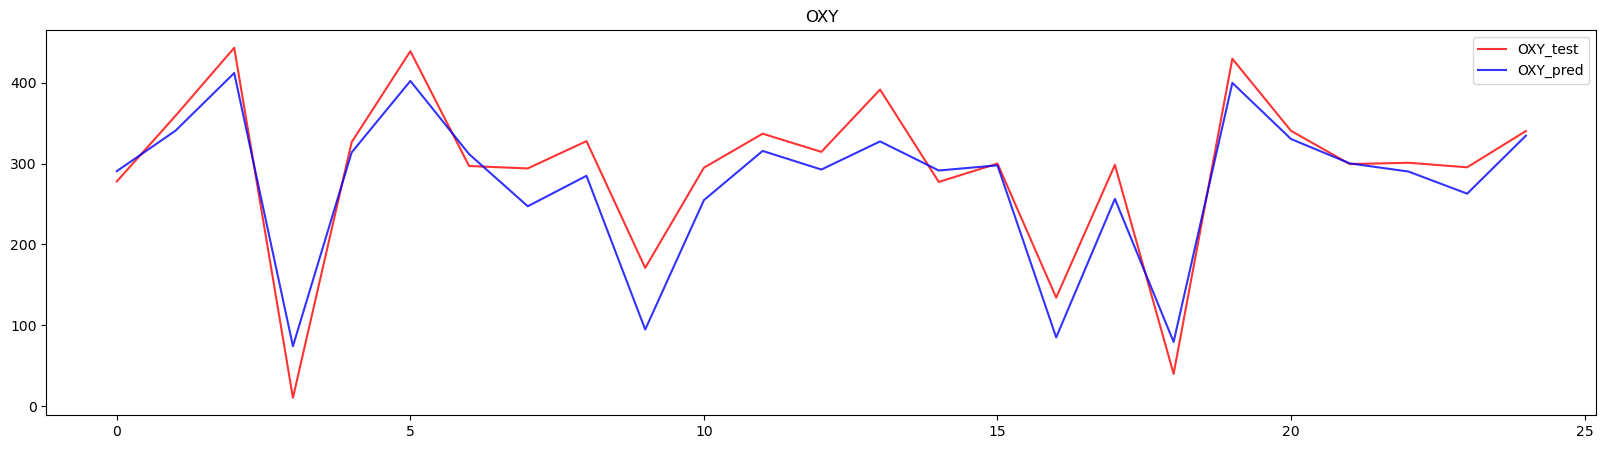

In [448]:
plt.figure(figsize=(20, 5))
plt.plot([i for i in range(y_test.shape[0])], y_test['OXY'], color='red', alpha=0.8, label="OXY_test")
plt.plot([i for i in range(y_test.shape[0])], y_pred['OXY'], color='blue', alpha=0.8, label="OXY_pred")
plt.legend(loc="upper right")
plt.title("OXY")
plt.show()

In [414]:
errors = abs(y_pred - y_test)
print('Mean Absolute Error:\n', np.round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error:
 OXY    22.14
TP      0.21
NO2     0.09
dtype: float64 degrees.


/var/folders/zf/z_5ht60d3n7gfsmz14cjq6fc0000gn/T/ipykernel_16604/2002337926.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(x_,y_test['TP'][-col:], label = 'tp_test')


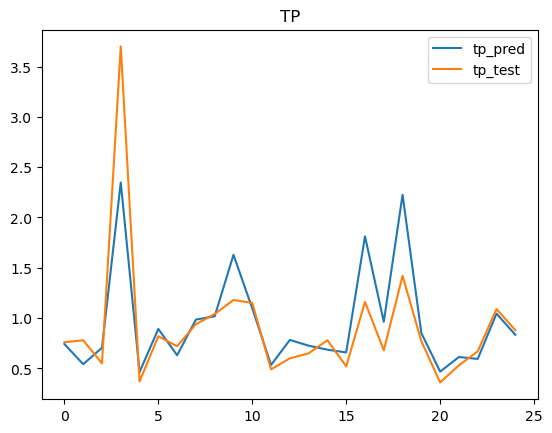

In [415]:
x_ = np.arange(col)
plt.plot(x_, df_y_pred['TP'], label = 'tp_pred')
plt.plot(x_,y_test['TP'][-col:], label = 'tp_test')
plt.title('TP')
plt.legend()
plt.show()